In [77]:
import pandas as pd

df = pd.read_csv('data/text_emotion.csv')

In [78]:
df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [79]:
df['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [80]:
len(df['sentiment'].unique())  #Number of different emotions

13

The average length of the sequences before padding is: 13.5158 words
The max length of the sequences before padding is: 37 words
The min length of the sequences before padding is: 1 words


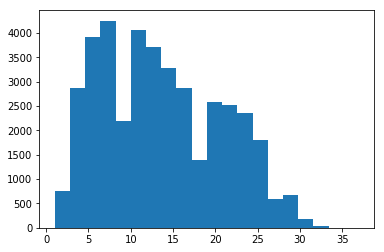

In [81]:
import numpy as np
import matplotlib.pyplot as plt

agg_list = np.array([len(i) for i in text])
avg_length = agg_list.mean()
max_length = np.array([len(i) for i in text]).max()
min_length = np.array([len(i) for i in text]).min()

print("The average length of the sequences before padding is: {} words".format(avg_length))
print("The max length of the sequences before padding is: {} words".format(max_length))
print("The min length of the sequences before padding is: {} words".format(min_length))

plt.hist(agg_list, bins = 20)
plt.show()

In [82]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

text = df['content']
labels = df['sentiment']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

text = tokenizer.texts_to_sequences(text)

#Setting the sequence length for the padding
seq_length = 30

sequences = pad_sequences(text, maxlen = seq_length)

In [83]:
emotion_dict = {}

for k in range(len(labels.unique())):
    emotion_dict[labels.unique()[k]] = k
    
print('Creating the emotion dict to encode the label')

Creating the emotion dict to encode the label


In [84]:
#Creating the encoded target

encoded_labels = np.array(list(labels.map(lambda x: emotion_dict[x])))

In [85]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(sequences)*split_frac)
train_x, val_x = sequences[:split_idx], sequences[split_idx:]
train_y, val_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape))

			Feature Shapes:
Train set: 		(32000, 30) 
Validation set: 	(8000, 30)


In [86]:
# First checking if GPU is available

import torch

train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


In [301]:
import torch.nn as nn

class Net(nn.Module):
    
    def __init__(self, num_layers, hidden_dim, 
                 embedding_dim, embedding_dict_size, 
                 seq_length, output_size):
        super(Net,self).__init__()
        
        self.n_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.embedding_dict_size = embedding_dict_size
        self.seq_length = seq_length
        self.output_size = output_size
        
        self.embedding = nn.Embedding(self.embedding_dict_size, self.embedding_dim)
        
        self.lstm = nn.LSTM(self.seq_length, self.hidden_dim, 
                            self.n_layers, batch_first = True)
        
        self.dropout = nn.Dropout()
        
        self.fc = nn.Linear(self.hidden_dim, output_size)

        
    def forward(self, x, hidden):
        
        embeds = self.embedding(x)
        embeds = embeds.view(batch_size,self.embedding_dim,self.seq_length)
        lstm_out, hidden = self.lstm(embeds)
        lstm_out = lstm_out.contiguous().view(batch_size, self.embedding_dim, self.hidden_dim)
        out = self.fc(lstm_out)
        out = out[:,-1,:]

        
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [307]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
val_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))

# dataloaders
batch_size = 64

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)

In [308]:
print(net)

Net(
  (embedding): Embedding(48998, 200)
  (lstm): LSTM(30, 50, batch_first=True)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=50, out_features=13, bias=True)
)


In [309]:
len(emotion_dict)

13

In [310]:
#Parameter settting

from torch import optim

num_layers = 1
hidden_dim = 50
output_size = len(df['sentiment'].unique())
embedding_dim = 200
vocab_size = len(tokenizer.word_index) + 1
output_size = len(emotion_dict)

learning_rate = 0.001

net = Net(num_layers, hidden_dim, embedding_dim, vocab_size, seq_length, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = learning_rate)

In [315]:
nb_epochs = 4
counter = 0
clip = 5
print_every = 128

if(train_on_gpu):
    net.cuda()

for epoch in range(nb_epochs):
    
    h = net.init_hidden(batch_size)
    net.train()
    
    for text_sequences, targets in train_loader:
        
        counter += 1
        
        #resetting the gradient
        net.zero_grad()
        
        if(train_on_gpu):
            text_sequences, targets = text_sequences.cuda(), targets.cuda()
            
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
            
        #Not sure why pytorch refuses the indices of text_sequences to be int.32
        input_text = text_sequences.type(torch.long)
        outputs, h = net(input_text, h) 
        loss = criterion(outputs, targets)
        loss.backward()
        
        #Clipping gradient to avoid exploding gradients
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        
        optimizer.step()
        
        if(counter % print_every == 0):
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            
            for text_sequences, targets in val_loader:
                # Get validation loss

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    text_sequences, targets = text_sequences.cuda(), targets.cuda()
                
                input_text = text_sequences.type(torch.long)
                outputs, val_h = net(input_text, val_h)
                val_loss = criterion(outputs, targets)

                val_losses.append(val_loss.item())
            
            net.train()
            print("Epoch: {}/{}...".format(epoch+1, nb_epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/4... Step: 128... Loss: 2.470800... Val Loss: 2.513041
Epoch: 1/4... Step: 256... Loss: 2.528027... Val Loss: 2.506971


KeyboardInterrupt: 